# Telecom Churn - ML Group Case Study

In [ ]:
# download data from https://drive.google.com/file/d/1SWnADIda31mVFevFcfkGtcgBHTKKI94J/view

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [195]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import seaborn as sns
import warnings

from imblearn.over_sampling import SMOTE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, accuracy_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = 250
pd.options.display.max_rows = 150

#  Load Data

In [3]:
df_tele_churn = pd.read_csv('telecom_churn_data.csv', encoding='ISO-8859-1')
df_tele_churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,5.44,0.00,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,na

In [4]:
df_tele_churn.shape

(99999, 226)

In [5]:
# Drop phone number because it doesn't matter
df_tele_churn = df_tele_churn.drop(columns=['mobile_number'])
df_tele_churn.shape

(99999, 225)

# Filter High Value Customer

In [6]:
# Find columns with recharge info
rech_cols = list(df_tele_churn.columns[df_tele_churn.columns.str.contains('rech_amt|rech_data')])
rech_cols

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_amt_9',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'max_rech_amt_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9']

In [7]:
df_tele_churn['total_rech_data_6'] = df_tele_churn['total_rech_data_6'].replace(np.NaN, 0)
df_tele_churn['total_rech_data_7'] = df_tele_churn['total_rech_data_7'].replace(np.NaN, 0)
df_tele_churn['total_rech_data_8'] = df_tele_churn['total_rech_data_8'].replace(np.NaN, 0)

df_tele_churn['av_rech_amt_data_6'] = df_tele_churn['av_rech_amt_data_6'].replace(np.NaN, 0)
df_tele_churn['av_rech_amt_data_7'] = df_tele_churn['av_rech_amt_data_7'].replace(np.NaN, 0)
df_tele_churn['av_rech_amt_data_8'] = df_tele_churn['av_rech_amt_data_8'].replace(np.NaN, 0)

# New feature: total data recharge amount
df_tele_churn['total_rech_data_amt_6'] = df_tele_churn['total_rech_data_6'] * df_tele_churn['av_rech_amt_data_6']
df_tele_churn['total_rech_data_amt_7'] = df_tele_churn['total_rech_data_7'] * df_tele_churn['av_rech_amt_data_7']
df_tele_churn['total_rech_data_amt_8'] = df_tele_churn['total_rech_data_8'] * df_tele_churn['av_rech_amt_data_8']

df_tele_churn.shape

(99999, 228)

In [8]:
# Average recharge amount in 6th and 7th Month
avg_rech_amt_6to7 = (df_tele_churn['total_rech_amt_6']
                     + df_tele_churn['total_rech_data_amt_6']
                     + df_tele_churn['total_rech_amt_7']
                     + df_tele_churn['total_rech_data_amt_7']) / 2

df_tele_churn['avg_rech_67'] = avg_rech_amt_6to7

# 70th Percentile of Avg Recharge Amount
seventy_percentile = np.percentile(avg_rech_amt_6to7, 70)
print('70th percentile in 6th and 7th months:', seventy_percentile)

# Select only rows above the 70th percentile
df_high_val_cust = df_tele_churn[avg_rech_amt_6to7 > seventy_percentile]
df_high_val_cust.shape

70th percentile in 6th and 7th months: 478.0


(29953, 229)

# Data Preperation & EDA

### Renaming columns for consistency

In [9]:
col_mapping = {
    'jun_vbc_3g': 'vbc_3g_6',
    'jul_vbc_3g': 'vbc_3g_7',
    'aug_vbc_3g': 'vbc_3g_8',
    'sep_vbc_3g': 'vbc_3g_9'
}

df_high_val_cust = df_high_val_cust.rename(columns=col_mapping)
df_high_val_cust.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,avg_rech_67
0,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,5.44,0.00,nan,

### Tag Churners

In [10]:
# Usage columns
df_high_val_cust[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].head()

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9
0,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00
8,34.91,142.18,0.00,0.00
21,252.61,1031.53,0.00,0.00
23,127.48,127.63,13.93,314.74


In [11]:
# If sum of row is 0 means they haven't used at all
total_usage = df_high_val_cust[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].sum(axis=1)
df_high_val_cust['churn'] = np.where(total_usage == 0, 1, 0)
df_high_val_cust.shape

(29953, 230)

In [12]:
# Drop 9th month columns
drop_cols = [col for col in df_high_val_cust.columns if '_9' in col]
df_high_val_cust = df_high_val_cust.drop(drop_cols, axis=1)
df_high_val_cust.shape

(29953, 175)

### Remove Columns with only 1 unique value

In [13]:
df_high_val_cust = df_high_val_cust.loc[:, df_high_val_cust.apply(pd.Series.nunique) != 1]
df_high_val_cust.shape

(29953, 162)

### Convert object columns

In [14]:
df_high_val_cust.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 162 columns):
arpu_6                      29953 non-null float64
arpu_7                      29953 non-null float64
arpu_8                      29953 non-null float64
onnet_mou_6                 29411 non-null float64
onnet_mou_7                 29417 non-null float64
onnet_mou_8                 28781 non-null float64
offnet_mou_6                29411 non-null float64
offnet_mou_7                29417 non-null float64
offnet_mou_8                28781 non-null float64
roam_ic_mou_6               29411 non-null float64
roam_ic_mou_7               29417 non-null float64
roam_ic_mou_8               28781 non-null float64
roam_og_mou_6               29411 non-null float64
roam_og_mou_7               29417 non-null float64
roam_og_mou_8               28781 non-null float64
loc_og_t2t_mou_6            29411 non-null float64
loc_og_t2t_mou_7            29417 non-null float64
loc_og_t2t_mou_8       

In [15]:
object_cols = df_high_val_cust.select_dtypes('object').columns

# Object columns are only dates columns
df_high_val_cust[object_cols] = df_high_val_cust[object_cols].apply(pd.to_datetime)

df_high_val_cust.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 162 columns):
arpu_6                      29953 non-null float64
arpu_7                      29953 non-null float64
arpu_8                      29953 non-null float64
onnet_mou_6                 29411 non-null float64
onnet_mou_7                 29417 non-null float64
onnet_mou_8                 28781 non-null float64
offnet_mou_6                29411 non-null float64
offnet_mou_7                29417 non-null float64
offnet_mou_8                28781 non-null float64
roam_ic_mou_6               29411 non-null float64
roam_ic_mou_7               29417 non-null float64
roam_ic_mou_8               28781 non-null float64
roam_og_mou_6               29411 non-null float64
roam_og_mou_7               29417 non-null float64
roam_og_mou_8               28781 non-null float64
loc_og_t2t_mou_6            29411 non-null float64
loc_og_t2t_mou_7            29417 non-null float64
loc_og_t2t_mou_8       

#### Utility Functions

In [16]:
# Box plot for 6th, 7th and 8th month
def box_plot(data, attribute):
    plt.figure(figsize=(20, 20))
    palette = 'Set1'
    
    plt.subplot(2, 3, 1)
    sns.boxplot(data=data, y=attribute+'_6', x='churn', hue='churn', showfliers=False, palette=palette)
    plt.grid()
    plt.legend(loc='upper right')
    
    plt.subplot(2, 3, 2)
    sns.boxplot(data=data, y=attribute+'_7', x='churn', hue='churn', showfliers=False, palette=palette)
    plt.grid()
    plt.legend(loc='upper right')
    
    plt.subplot(2, 3, 3)
    sns.boxplot(data=data, y=attribute+'_8', x='churn', hue='churn', showfliers=False, palette=palette)
    plt.grid()
    plt.legend(loc='upper right')
    
    plt.show()

In [31]:
# Mean bar plot of churn and non-churn against other attribute
def bar_plot(data, cols):
    data_churn = data[data['churn'] == 0][cols]
    data_non_churn = data[data['churn'] == 1][cols]
    
    mean_data_churn = pd.DataFrame([data_churn.mean()], index={'Non Churn'})
    mean_data_non_churn = pd.DataFrame([data_non_churn.mean()], index={'Churn'})

    mean_bar = pd.concat([mean_data_churn, mean_data_non_churn])

    mean_bar.T.plot.bar(rot=0, figsize=(15, 10), colormap='Set1')
    plt.grid()
    plt.show()
    
    return mean_bar

### 2G/3G Usage

In [26]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
usage_columns = num_cols_df.columns[num_cols_df.columns.str.contains('2g|3g')]
list(usage_columns)

['count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'vol_2g_mb_6',
 'vol_2g_mb_7',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'vol_3g_mb_7',
 'vol_3g_mb_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'vbc_3g_8',
 'vbc_3g_7',
 'vbc_3g_6']

In [27]:
100 * df_high_val_cust[usage_columns].isnull().sum() / len(df_high_val_cust)

count_rech_2g_6   44.11
count_rech_2g_7   43.12
count_rech_2g_8   46.80
count_rech_3g_6   44.11
count_rech_3g_7   43.12
count_rech_3g_8   46.80
vol_2g_mb_6        0.00
vol_2g_mb_7        0.00
vol_2g_mb_8        0.00
vol_3g_mb_6        0.00
vol_3g_mb_7        0.00
vol_3g_mb_8        0.00
arpu_3g_6         44.11
arpu_3g_7         43.12
arpu_3g_8         46.80
arpu_2g_6         44.11
arpu_2g_7         43.12
arpu_2g_8         46.80
monthly_2g_6       0.00
monthly_2g_7       0.00
monthly_2g_8       0.00
sachet_2g_6        0.00
sachet_2g_7        0.00
sachet_2g_8        0.00
monthly_3g_6       0.00
monthly_3g_7       0.00
monthly_3g_8       0.00
sachet_3g_6        0.00
sachet_3g_7        0.00
sachet_3g_8        0.00
vbc_3g_8           0.00
vbc_3g_7           0.00
vbc_3g_6           0.00
dtype: float64

In [28]:
# We can drop these columns since we have usage volume data (vol_ & vbc)
drop_cols = [
    'count_rech_2g_6','count_rech_2g_7', 'count_rech_2g_8',
    'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8',
    'arpu_3g_6','arpu_3g_7','arpu_3g_8',
    'arpu_2g_6','arpu_2g_7','arpu_2g_8'
]

df_high_val_cust = df_high_val_cust.drop(drop_cols, axis=1)
df_high_val_cust.shape

(29953, 150)

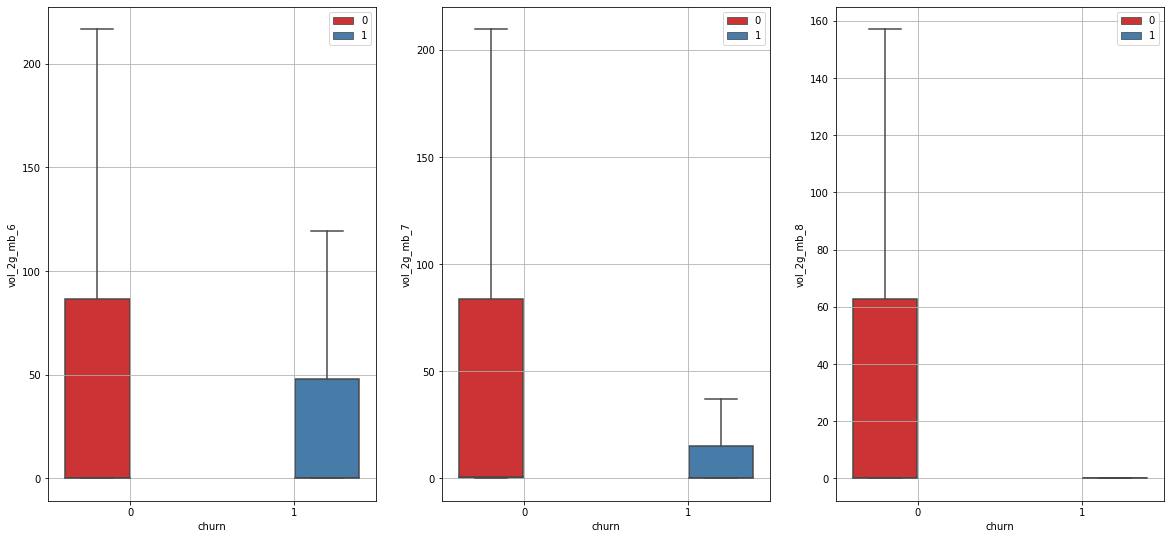

In [29]:
box_plot(df_high_val_cust, 'vol_2g_mb')

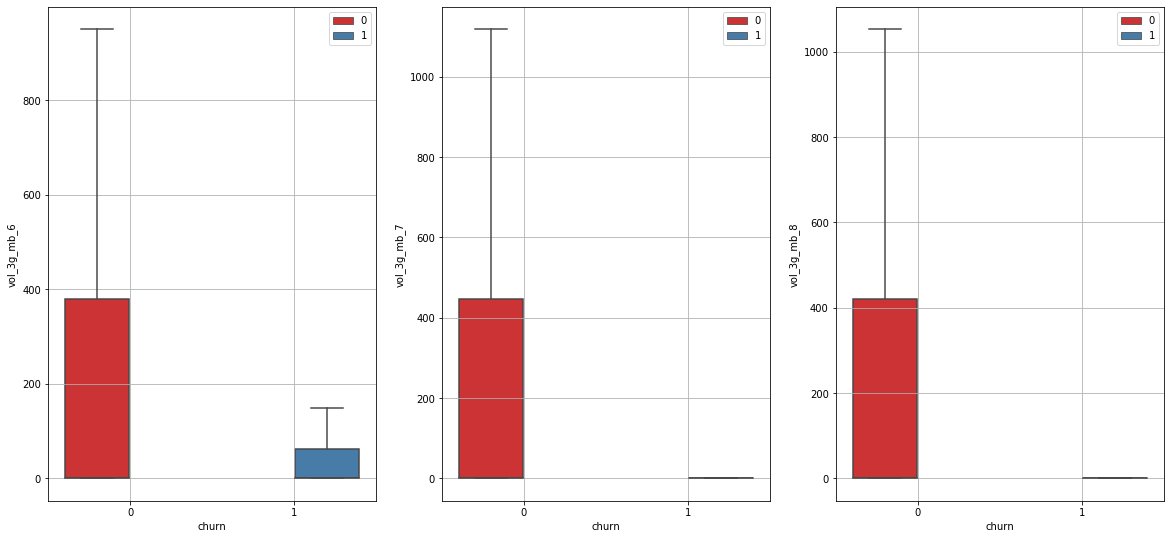

In [30]:
box_plot(df_high_val_cust, 'vol_3g_mb')

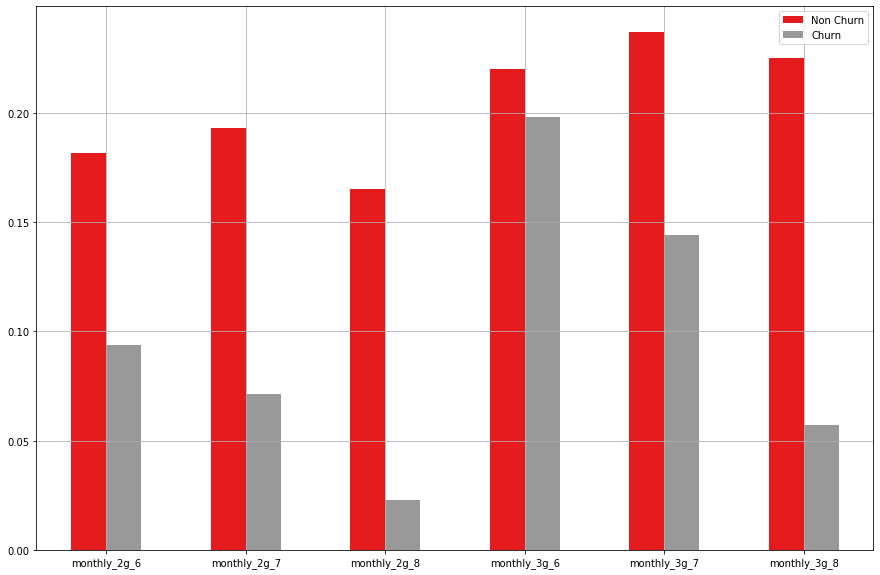

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.18,0.19,0.17,0.22,0.24,0.22
Churn,0.09,0.07,0.02,0.20,0.14,0.06


In [32]:
monthly_cols = [
    'monthly_2g_6',
    'monthly_2g_7',
    'monthly_2g_8',
    'monthly_3g_6',
    'monthly_3g_7',
    'monthly_3g_8'
]
bar_plot(df_high_val_cust, monthly_cols)

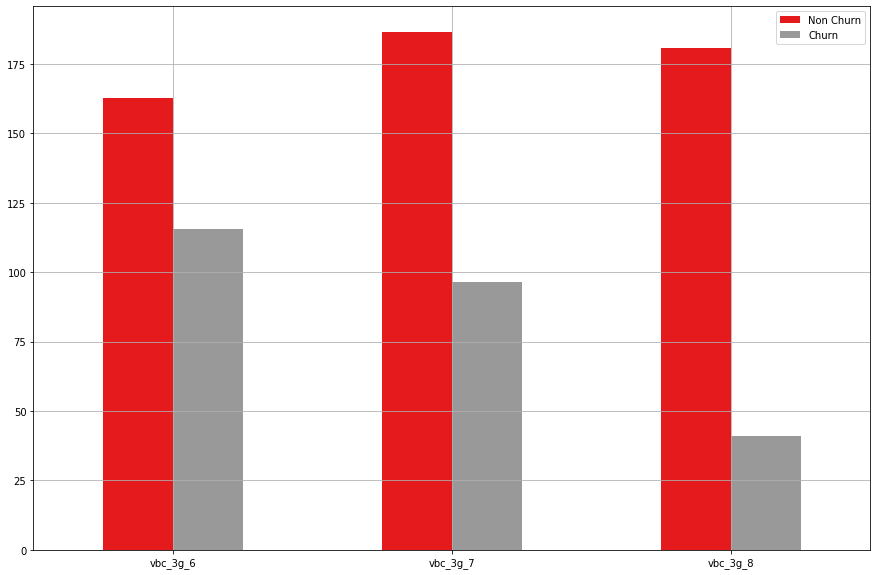

,vbc_3g_6,vbc_3g_7,vbc_3g_8
Non Churn,162.56,186.37,180.62
Churn,115.46,96.34,40.94


In [33]:
vbc_cols = ['vbc_3g_6', 'vbc_3g_7', 'vbc_3g_8']
bar_plot(df_high_val_cust, vbc_cols)

- Volume Based Cost for users drop significantly for 8th month for churned customers

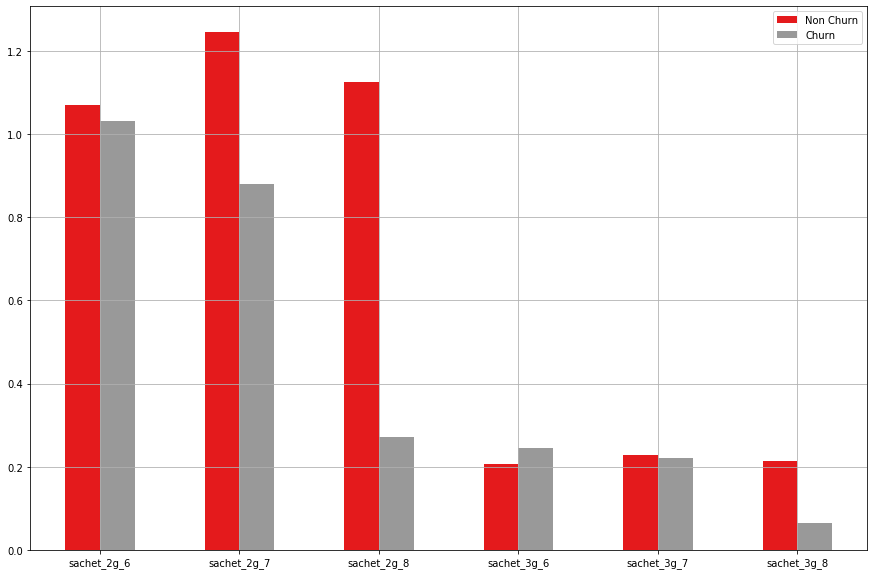

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,1.07,1.25,1.13,0.21,0.23,0.21
Churn,1.03,0.88,0.27,0.24,0.22,0.07


In [34]:
sachet_cols = [
    'sachet_2g_6',
    'sachet_2g_7',
    'sachet_2g_8',
    'sachet_3g_6',
    'sachet_3g_7',
    'sachet_3g_8'
]
bar_plot(df_high_val_cust, sachet_cols)

- We see the same pattern in these variables as well

### ARPU (Average Revenue Per User)

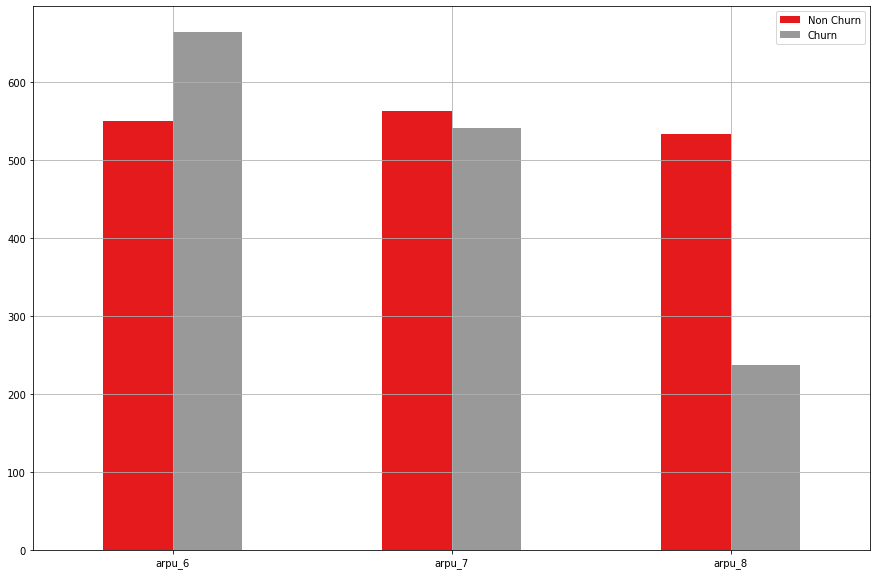

,arpu_6,arpu_7,arpu_8
Non Churn,549.55,562.93,532.87
Churn,663.71,541.15,237.66


In [35]:
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
bar_plot(df_high_val_cust, arpu_cols)

- Drop in 8th month for churned customers again

### Recharge Amount Variables

In [17]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
rech_columns = num_cols_df.columns[num_cols_df.columns.str.contains('rech_data|rech_amt|rech_num|max_rech_data')]
list(rech_columns)

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_data_amt_6',
 'total_rech_data_amt_7',
 'total_rech_data_amt_8']

In [18]:
100 * df_high_val_cust[rech_columns].isnull().sum() / len(df_high_val_cust)

total_rech_num_6         0.00
total_rech_num_7         0.00
total_rech_num_8         0.00
total_rech_amt_6         0.00
total_rech_amt_7         0.00
total_rech_amt_8         0.00
max_rech_amt_6           0.00
max_rech_amt_7           0.00
max_rech_amt_8           0.00
total_rech_data_6        0.00
total_rech_data_7        0.00
total_rech_data_8        0.00
max_rech_data_6         44.11
max_rech_data_7         43.12
max_rech_data_8         46.80
av_rech_amt_data_6       0.00
av_rech_amt_data_7       0.00
av_rech_amt_data_8       0.00
total_rech_data_amt_6    0.00
total_rech_data_amt_7    0.00
total_rech_data_amt_8    0.00
dtype: float64

In [19]:
df_high_val_cust['max_rech_data_6'] = df_high_val_cust['max_rech_data_6'].replace(np.NaN, 0)
df_high_val_cust['max_rech_data_7'] = df_high_val_cust['max_rech_data_7'].replace(np.NaN, 0)
df_high_val_cust['max_rech_data_8'] = df_high_val_cust['max_rech_data_8'].replace(np.NaN, 0)

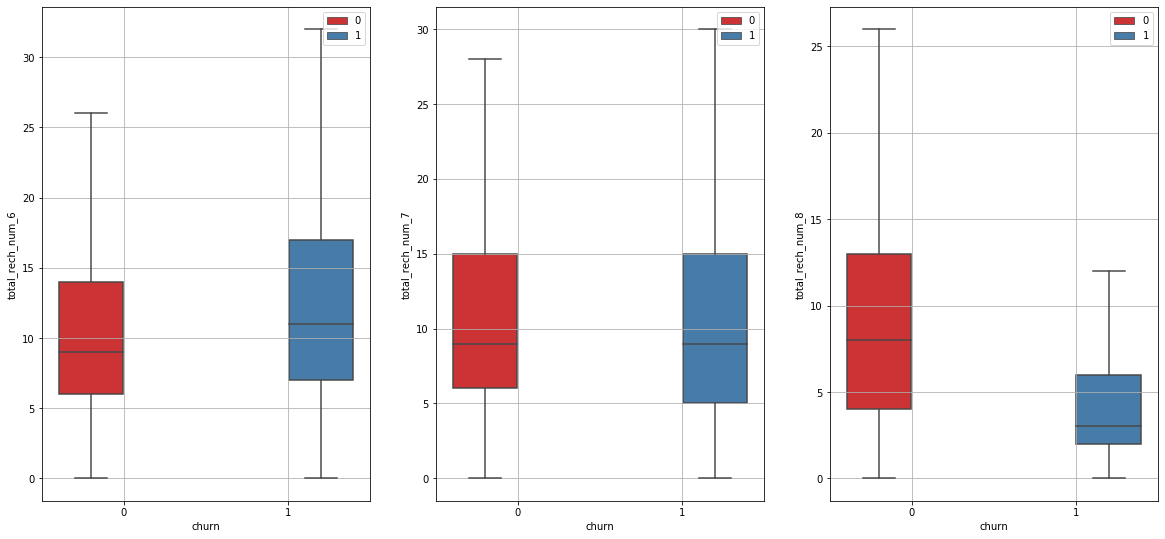

In [20]:
box_plot(df_high_val_cust, 'total_rech_num')

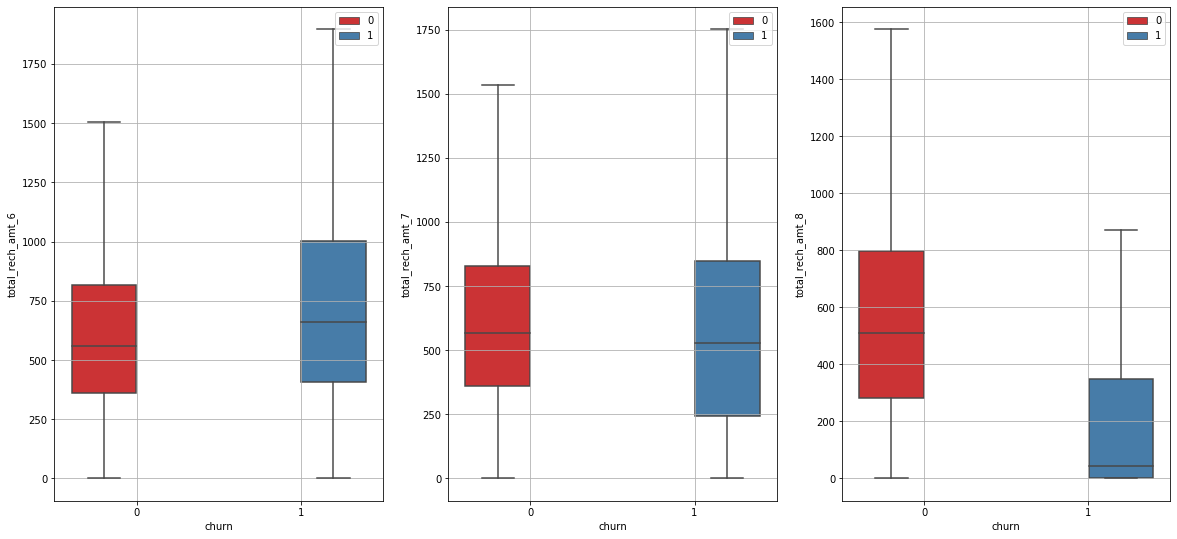

In [21]:
box_plot(df_high_val_cust, 'total_rech_amt')

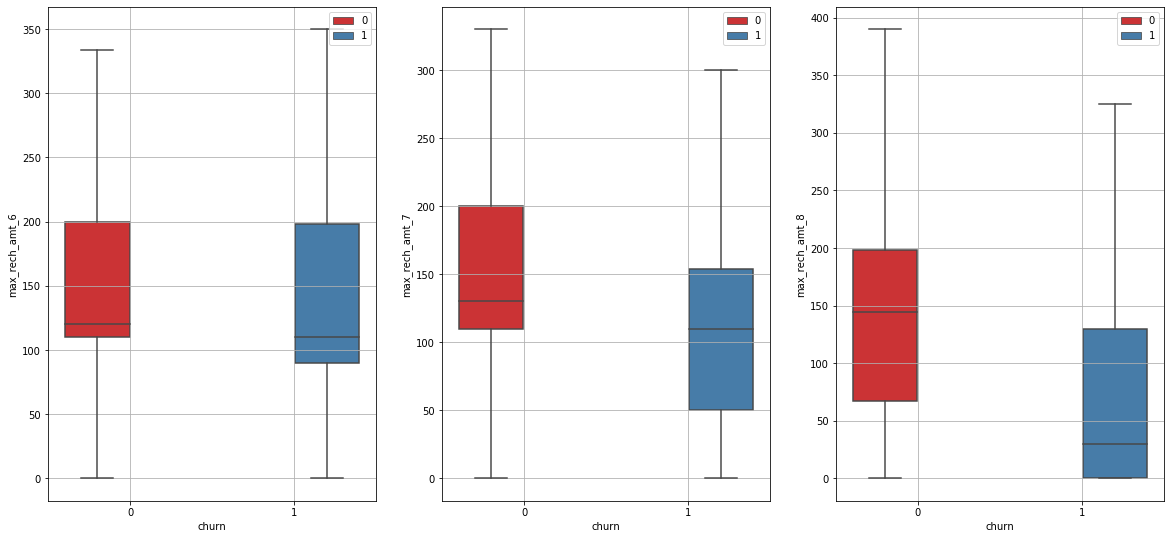

In [22]:
box_plot(df_high_val_cust, 'max_rech_amt')

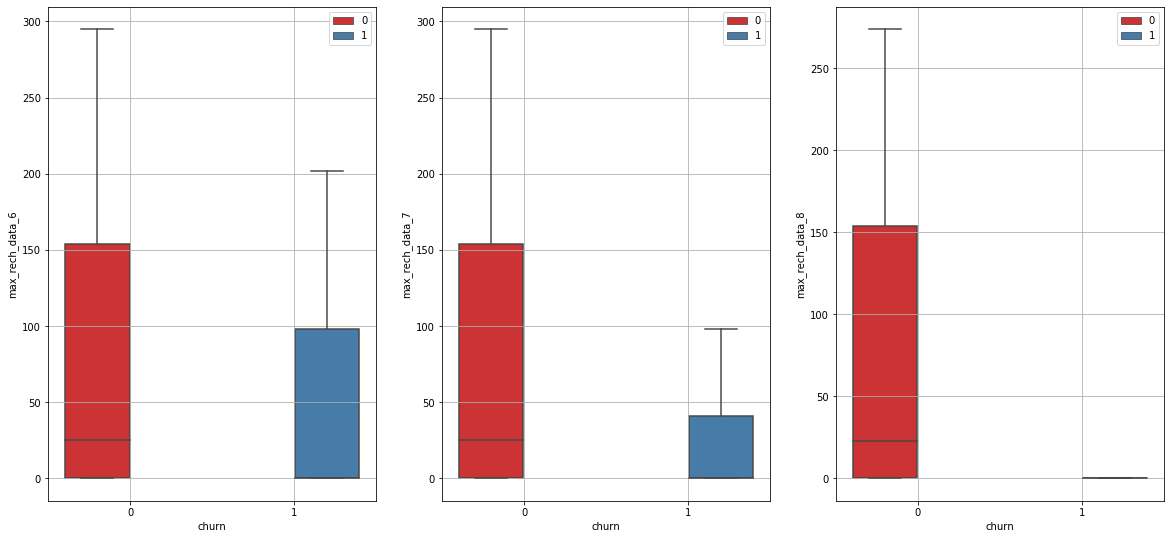

In [23]:
box_plot(df_high_val_cust, 'max_rech_data')

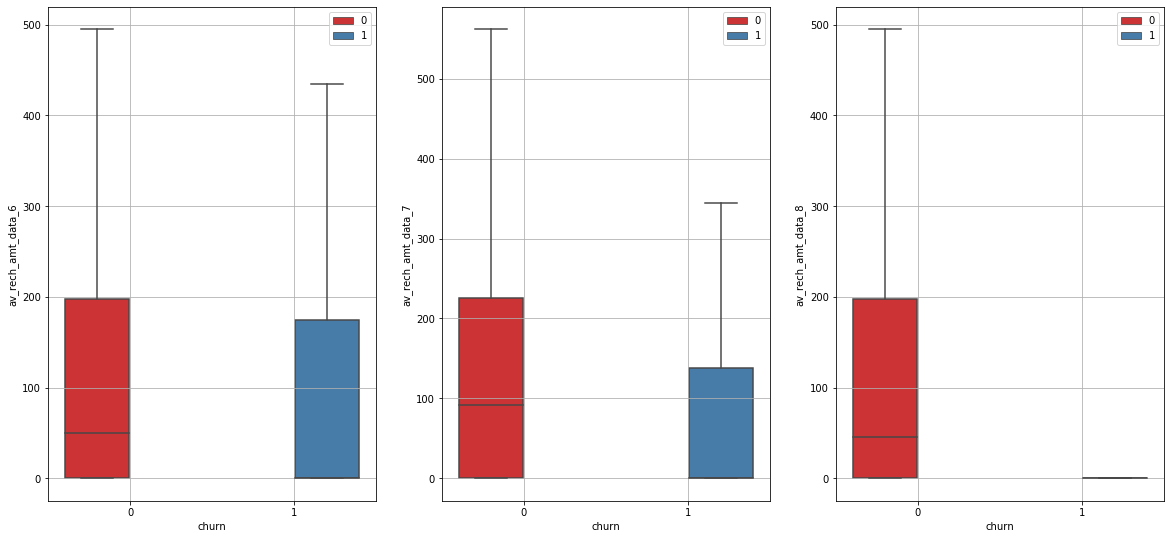

In [24]:
box_plot(df_high_val_cust, 'av_rech_amt_data')

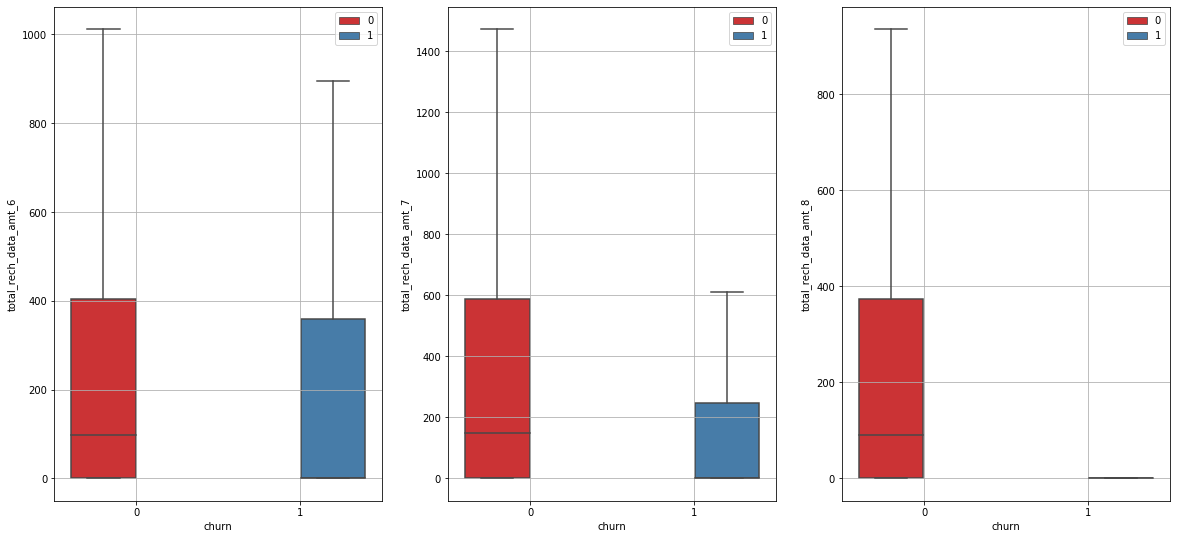

In [25]:
box_plot(df_high_val_cust, 'total_rech_data_amt')

- In all cases we see drop for churned customers in the respective values in the 8th month

### MOU (Minutes of Usage)

In [36]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
mou_columns = num_cols_df.columns[num_cols_df.columns.str.contains('mou')]
list(mou_columns)

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_i

In [37]:
(100 * df_high_val_cust[mou_columns].isnull().sum() / len(df_high_val_cust)).sort_values(ascending=False)

isd_ic_mou_8       3.91
loc_og_t2m_mou_8   3.91
spl_og_mou_8       3.91
std_og_mou_8       3.91
std_og_t2f_mou_8   3.91
std_og_t2m_mou_8   3.91
loc_ic_t2t_mou_8   3.91
std_og_t2t_mou_8   3.91
loc_ic_t2m_mou_8   3.91
loc_og_mou_8       3.91
loc_ic_t2f_mou_8   3.91
loc_og_t2c_mou_8   3.91
loc_ic_mou_8       3.91
isd_og_mou_8       3.91
std_ic_t2t_mou_8   3.91
loc_og_t2f_mou_8   3.91
std_ic_t2m_mou_8   3.91
onnet_mou_8        3.91
loc_og_t2t_mou_8   3.91
spl_ic_mou_8       3.91
std_ic_t2f_mou_8   3.91
roam_og_mou_8      3.91
std_ic_mou_8       3.91
offnet_mou_8       3.91
roam_ic_mou_8      3.91
roam_ic_mou_6      1.81
std_og_mou_6       1.81
offnet_mou_6       1.81
std_og_t2f_mou_6   1.81
roam_og_mou_6      1.81
std_og_t2m_mou_6   1.81
loc_og_t2f_mou_6   1.81
std_og_t2t_mou_6   1.81
loc_og_mou_6       1.81
loc_og_t2t_mou_6   1.81
loc_og_t2c_mou_6   1.81
loc_og_t2m_mou_6   1.81
isd_og_mou_6       1.81
onnet_mou_6        1.81
spl_og_mou_6       1.81
loc_ic_t2t_mou_6   1.81
std_ic_t2t_mou_6

In [38]:
# We can assume nan values are customers who didnt use at all
df_high_val_cust[mou_columns] = df_high_val_cust[mou_columns].replace(np.NaN, 0)

#### Outgoing Usage

In [39]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
og_mou_columns = num_cols_df.columns[num_cols_df.columns.str.contains('.*_og_.*mou_6')]
list(og_mou_columns)

['roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'total_og_mou_6']

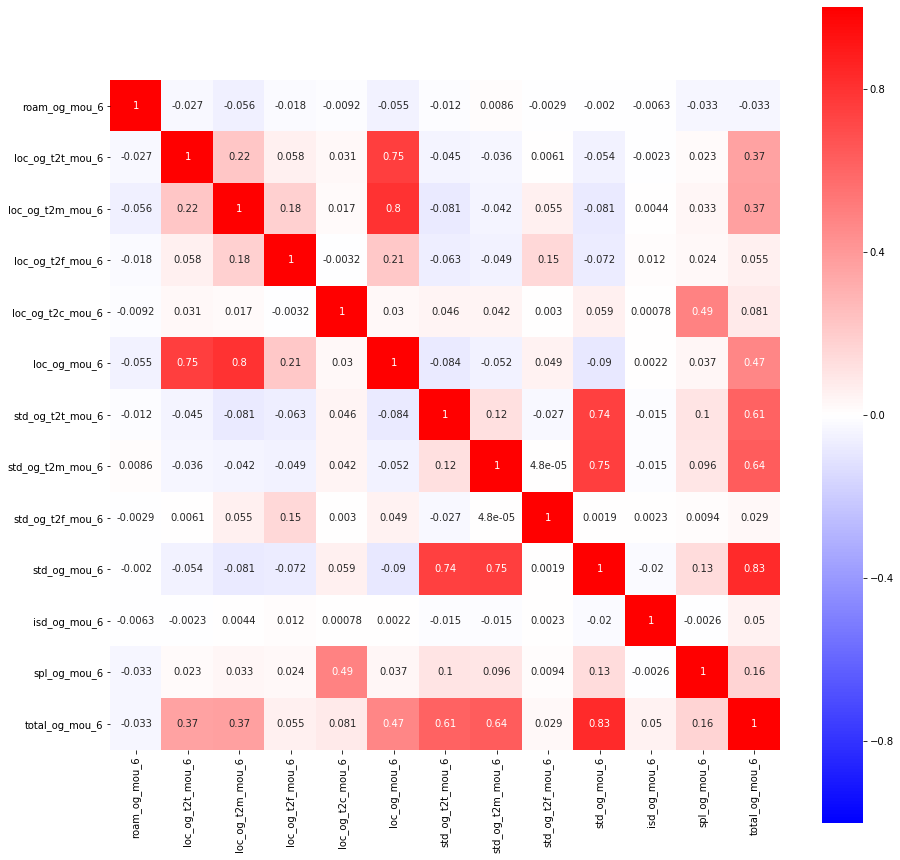

In [40]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df_high_val_cust[og_mou_columns].corr(), cmap='bwr', annot=True, square=True, vmin=-1, vmax=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

- loc_og_mou_6, std_og_mou_6 and total_og_mou_6 have strong correlation with other variables
- loc_og_mou could be sum of all loc_og
- total_og_mou could be sum of all og_mou
- std_og_mou could be sum of all std_og

In [41]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
loc_og_columns = num_cols_df.columns[num_cols_df.columns.str.contains('loc_og.*_6')]
print(df_high_val_cust[loc_og_columns[:-1]].iloc[2].sum().round(2))
print(df_high_val_cust[loc_og_columns[-1]].iloc[2].sum().round(2))

378.09
378.09


In [42]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
og_mou_columns = num_cols_df.columns[num_cols_df.columns.str.contains('og_mou.*_6')]
print(df_high_val_cust[og_mou_columns[:-1]].iloc[2].sum().round(2))
print(df_high_val_cust[og_mou_columns[-1]].iloc[2].sum().round(2))

508.35
508.36


In [43]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
std_og_columns = num_cols_df.columns[num_cols_df.columns.str.contains('std_og.*_6')]
print(df_high_val_cust[std_og_columns[:-1]].iloc[2].sum().round(2))
print(df_high_val_cust[std_og_columns[-1]].iloc[2].sum().round(2))

130.25
130.26


These columns are sum of other columns. So, we can drop them for all months.

In [44]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
drop_cols = num_cols_df.columns[num_cols_df.columns.str.contains('loc_og_mou|std_og_mou|total_og_mou')]

df_high_val_cust = df_high_val_cust.drop(drop_cols, axis=1)
list(drop_cols)

['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

#### Incoming Usage

In [45]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
ic_mou_columns = num_cols_df.columns[num_cols_df.columns.str.contains('.*_ic_.*mou_6')]
list(ic_mou_columns)

['roam_ic_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6']

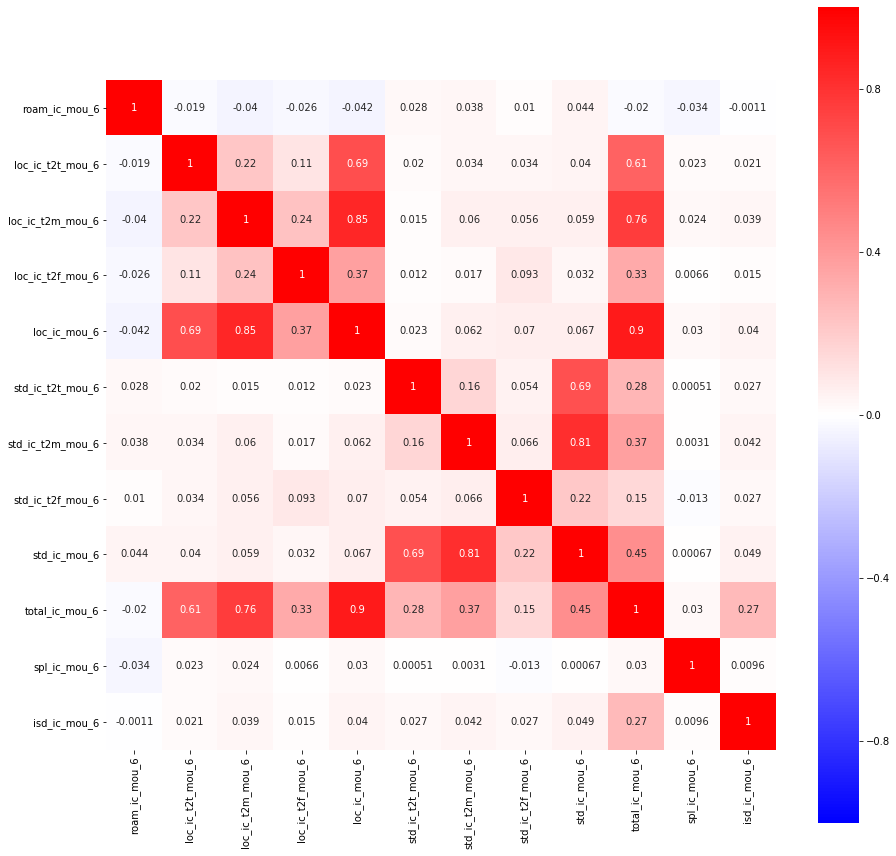

In [46]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df_high_val_cust[ic_mou_columns].corr(), cmap='bwr', annot=True, square=True, vmin=-1, vmax=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

- We can see the same pattern as the outgoing usage

In [47]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
loc_ic_columns = num_cols_df.columns[num_cols_df.columns.str.contains('loc_ic.*_6')]
print(df_high_val_cust[loc_ic_columns[:-1]].iloc[2].sum().round(2))
print(df_high_val_cust[loc_ic_columns[-1]].iloc[2].sum().round(2))

81.42
81.43


In [48]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
ic_mou_columns = num_cols_df.columns[num_cols_df.columns.str.contains('ic_mou.*_6')]
ic_mou_sum_cols = ['roam_ic_mou_6', 'loc_ic_mou_6', 'std_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6']
print(df_high_val_cust[ic_mou_sum_cols].iloc[2].sum().round(2))
print(df_high_val_cust['total_ic_mou_6'].iloc[2].sum().round(2))

103.86
103.86


In [49]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
std_ic_columns = num_cols_df.columns[num_cols_df.columns.str.contains('std_ic.*_6')]
print(df_high_val_cust[std_ic_columns[:-1]].iloc[2].sum().round(2))
print(df_high_val_cust[std_ic_columns[-1]].iloc[2].sum().round(2))

22.43
22.43


In [50]:
num_cols_df = df_high_val_cust.select_dtypes(include=['float', 'int'])
drop_cols = num_cols_df.columns[num_cols_df.columns.str.contains('loc_ic_mou|std_ic_mou|total_ic_mou')]

df_high_val_cust = df_high_val_cust.drop(drop_cols, axis=1)
list(drop_cols)

['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

#### Offnet (All kind of calls outside the operator T network)

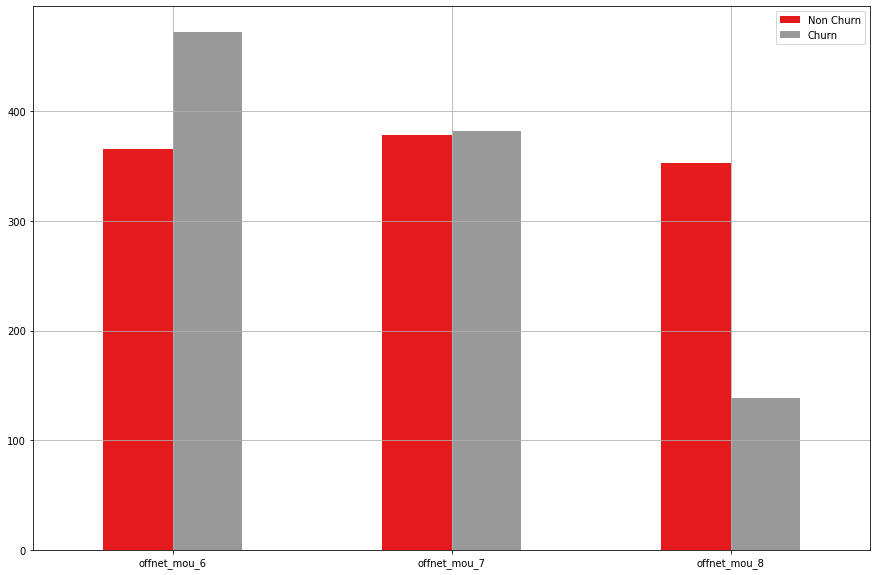

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Non Churn,365.12,377.88,352.50
Churn,471.95,382.28,138.52


In [51]:
offnet_colums = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
bar_plot(df_high_val_cust, offnet_colums)

- Drop in Offnet usage in 8th month for churned customer

#### Onnet (All kind of calls within the same operator network)

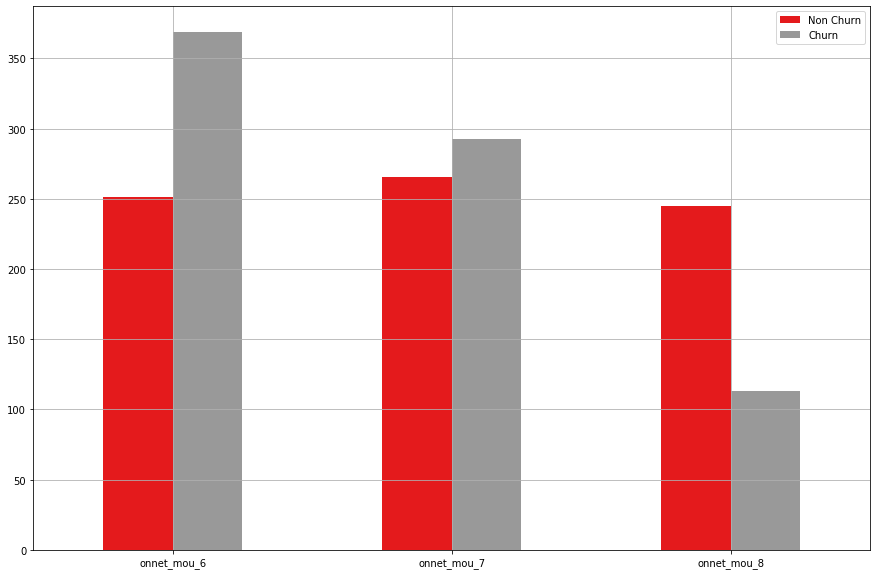

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Non Churn,251.37,265.86,245.03
Churn,368.66,292.85,113.48


In [52]:
onnet_columns = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
bar_plot(df_high_val_cust, onnet_columns)

- Drop in Onnet usage in 8th month for churned customer

### AON (Age on Network)

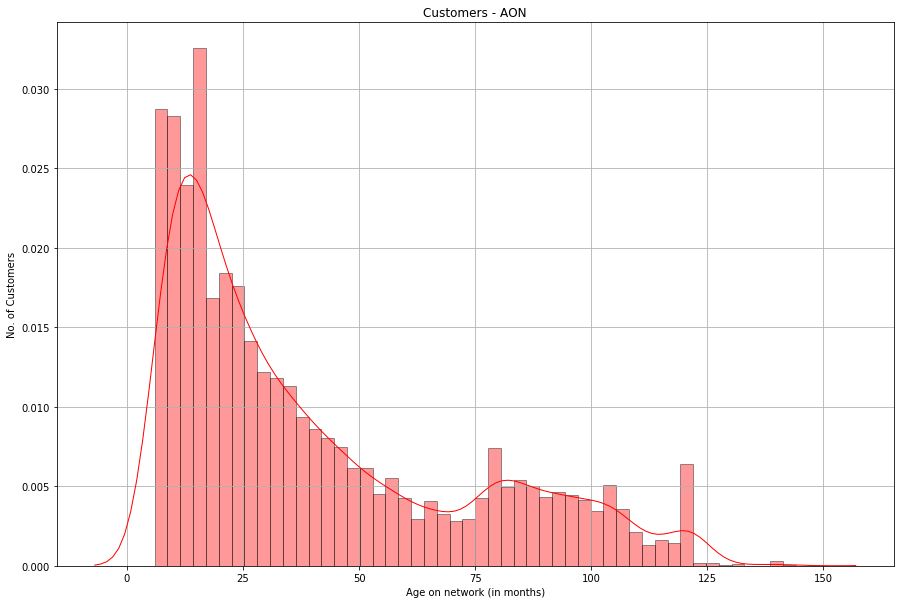

In [53]:
aon_data = df_high_val_cust.copy()

aon_data['aon_mon'] = aon_data['aon'] / 30 # Convert days to months

plt.figure(figsize=(15, 10))
ax = sns.distplot(aon_data['aon_mon'], hist=True, kde=True, color='red',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})
ax.set_ylabel('No. of Customers')
ax.set_xlabel('Age on network (in months)')
ax.set_title('Customers - AON')

plt.grid()

In [54]:
# Clubbing age on network
aon_range = [0, 12, 24, 60, 160]
aon_label = ['0-1 year', '1-2 years', '2-5 years', '+5 years']
aon_data['aon_range'] = pd.cut(aon_data['aon_mon'], aon_range, labels=aon_label)
aon_data['aon_range'].head()

0     2-5 years
7     2-5 years
8      0-1 year
21    1-2 years
23    1-2 years
Name: aon_range, dtype: category
Categories (4, object): [0-1 year < 1-2 years < 2-5 years < +5 years]

In [55]:
aon_data

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,avg_rech_67,churn,aon_mon,aon_range
0,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,2014-06-21,2014-07-16,2014-08-08,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1,32.27,2-5 years
7,1069.18,1349.85,3171.48,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,NaT,NaT,NaT,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,802,57.74,19.38,18.74,0.00,0.00,0.00,1185.00,1,26.73,2-5 years
8,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,2014-06-25,2014-07-31,2014-08-30,50,0,10,NaT,2014-07-31,2014-08-23,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,nan,0.00,0.00,0

Text(0.5, 1.0, 'Customers - AON Range')

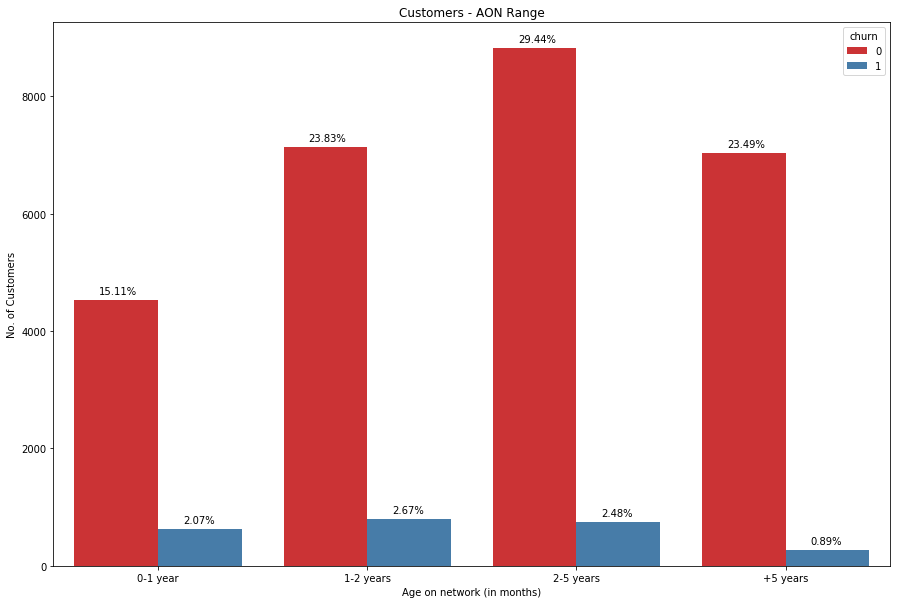

In [56]:
plt.figure(figsize=(15, 10))
ax = sns.countplot(x='aon_range', data=aon_data, hue='churn', palette='Set1')

for p in ax.patches:
    percentage = round((p.get_height()*100)/float(len(aon_data)), 2)
    ax.annotate('{:.2f}%'.format(percentage), (p.get_x() + 0.12, p.get_height() + 100))
    
ax.set_ylabel('No. of Customers')
ax.set_xlabel('Age on network (in months)')
ax.set_title('Customers - AON Range')

- Customers on network for less than 5 years are more likely to churn

### Drop columns with > 40% of missing values

In [57]:
missing = pd.DataFrame(df_high_val_cust.isnull().sum() * 100 / len(df_high_val_cust)).reset_index()
missing.columns = ['column', 'percentage']

# Drop columns with >= 40% of missing values
drop_cols = missing.loc[missing['percentage'] >= 40]['column']
drop_cols

87     date_of_last_rech_data_6
88     date_of_last_rech_data_7
89     date_of_last_rech_data_8
105            night_pck_user_6
106            night_pck_user_7
107            night_pck_user_8
120                   fb_user_6
121                   fb_user_7
122                   fb_user_8
Name: column, dtype: object

In [58]:
# Drop them!
df_high_val_cust = df_high_val_cust.drop(drop_cols, axis=1)
df_high_val_cust.shape

(29953, 123)

In [59]:
missing = pd.DataFrame(df_high_val_cust.isnull().sum() * 100 / len(df_high_val_cust)).reset_index()
missing.columns = ['column', 'percentage']

# Drop columns with >= 0% of missing values
drop_cols = missing.loc[missing['percentage'] > 0]['column']
drop_cols

42            og_others_6
43            og_others_7
44            og_others_8
69            ic_others_6
70            ic_others_7
71            ic_others_8
81    date_of_last_rech_6
82    date_of_last_rech_7
83    date_of_last_rech_8
Name: column, dtype: object

In [60]:
# Setting null values to 0 for numeric columns
df_high_val_cust[drop_cols[:-3]] = df_high_val_cust[drop_cols[:-3]].replace(np.NaN, 0)

In [61]:
# Drop date columns since it will not have any impact
date_cols = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
df_high_val_cust = df_high_val_cust.drop(date_cols, axis=1)
df_high_val_cust.shape

(29953, 120)

In [62]:
# Checkpoint!
final_df = df_high_val_cust.copy()

# Derive New Features

In [63]:
final_df = final_df.drop('avg_rech_67', axis=1)

# Calculate average of 6th and 7th month (Good Phase) for each feature
cols_67 = final_df.filter(regex='_6|_7').columns
col_list = cols_67.str[:-2].unique() # unique columns without underscore number

# Averaging the columns
for idx, col in enumerate(col_list):
    avg_col = 'avg_' + col + '_67'
    
    col_6 = col + '_6'
    col_7 = col + '_7'
    
    final_df[avg_col] = (final_df[col_6]  + final_df[col_7]) / 2


# Drop original columns
final_df = final_df.drop(cols_67, axis=1)
final_df.shape

(29953, 80)

# Modelling

In [64]:
model_df = final_df.copy()
model_df.shape

(29953, 80)

In [65]:
X = model_df.drop(['churn'], axis=1)
y = model_df['churn']

<Figure size 720x720 with 0 Axes>

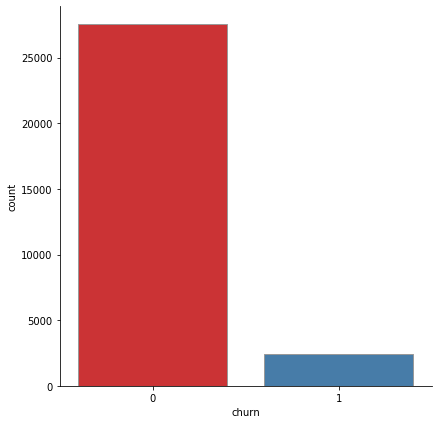

In [66]:
# Churn Distribution
plt.figure(figsize=(10, 10))
sns.catplot(x='churn', data=model_df, kind='count', palette='Set1', edgecolor='.6', size=6, aspect=1)

- There is a clear imbalance in class. This could affect our final outcome of the model. We will use Smote to deal with.

In [67]:
cols = X.columns
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=cols)

X_scaled_df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_data_amt_8,avg_arpu_67,avg_onnet_mou_67,avg_offnet_mou_67,avg_roam_ic_mou_67,avg_roam_og_mou_67,avg_loc_og_t2t_mou_67,avg_loc_og_t2m_mou_67,avg_loc_og_t2f_mou_67,avg_loc_og_t2c_mou_67,avg_std_og_t2t_mou_67,avg_std_og_t2m_mou_67,avg_std_og_t2f_mou_67,avg_isd_og_mou_67,avg_spl_og_mou_67,avg_og_others_67,avg_loc_ic_t2t_mou_67,avg_loc_ic_t2m_mou_67,avg_loc_ic_t2f_mou_67,avg_std_ic_t2t_mou_67,avg_std_ic_t2m_mou_67,avg_std_ic_t2f_mou_67,avg_spl_ic_mou_67,avg_isd_ic_mou_67,avg_ic_others_67,avg_total_rech_num_67,avg_total_rech_amt_67,avg_max_rech_amt_67,avg_last_day_rch_amt_67,avg_total_rech_data_67,avg_max_rech_data_67,avg_av_rech_amt_data_67,avg_vol_2g_mb_67,avg_vol_3g_mb_67,avg_monthly_2g_67,avg_sachet_2g_67,avg_monthly_3g_67,avg_sachet_3g_67,avg_vbc_3g_67,avg_total_rech_data_amt_67
0,-0.59,-0.51,-0.70,-0.17,-0.19,-0.34,-0.65,-0.30,-0.24,-0.37,-0.38,-0.15,-0.04,-0.32,-0.02,-0.39,-0.66,-0.31,-0.19,-0.27,-0.13,-0.24,-0.16,-0.10,-0.86,-0.54,0.53,1.10,-0.21,1.62,0.66,-0.32,-0.26,-0.38,-0.42,1.28,-0.18,-0.25,-0.33,-0.13,-0.82,-0.60,-0.82,-0.22,-0.25,-0.38,-0.70,-0.30,-0.27,-0.44,-0.47,-0.16,-0.05,-0.37,-0.14,-0.42,-0.73,-0.35,-0.20,-0.32,-0.15,-0.27,-0.15,-0.10,-0.96,-0.69,0.53,1.30,-0.28,1.68,0.64,-0.37,-0.29,-0.46,-0.47,1.36,-0.23,-0.30,-0.19
1,5.30,-0.40,-0.02,0.26,0.17,-0.17,0.04,2.43,-0.24,-0.34,-0.26,1.38,0.18,-0.00,-0.02,-0.22,-0.12,0.58,0.23,1.10,0.99,-0.24,0.29,1.09,-0.32,4.99,8.19,4.73,-0.54,-0.66,-0.62,-0.34,-0.38,-0.38,-0.42,-0.34,-0.18,-0.43,-0.26,-0.29,1.51,-0.47,0.29,0.16,-0.06,-0.20,0.92,2.49,-0.27,-0.41,-0.36,1.00,-0.05,-0.24,-0.14,-0.13,0.33,2.50,0.12,0.84,2.26,0.43,-0.04,1.03,-0.79,1.02,6.57,-0.87,-0.65,-0.77,-0.74,-0.42,-0.43,-0.46,-0.47,-0.39,-0.23,-0.38,-0.40
2,-0.74,-0.43,-0.41,-0.17,-0.19,-0.29,-0.43,-0.30,0.76,-0.32,-0.20,-0.15,-0.04,0.18,-0.02,-0.39,-0.61,-0.33,-0.19,-0.26,-0.13,-0.24,-0.16,-0.10,0.43,-0.76,-0.75,-0.57,0.46,-0.45,-0.27,-0.34,-0.37,-0.38,0.77,-0.34,-0.18,-0.93,-0.35,-0.16,-0.29,0.27,-0.63,-0.22,-0.25,0.77,-0.38,-0.30,-0.27,-0.12,-0.44,-0.16,-0.05,-0.37,-0.14,-0.31,-0.56,-0.35,-0.20,-0.18,-0.15,-0.27,-0.15,-0.10,0.95,-0.28,-0.32,-0.65,-0.28,-0.02,-0.26,0.17,0.02,0.83,-0.27,-0.39,-0.23,0.88,-0.25
3,0.26,-0.33,1.35,-0.17,-0.19,-0.24,-0.20,-0.22,-0.24,-0.22,1.76,-0.15,-0.04,-0.32,-0.02,-0.27,-0.08,-0.09,-0.19,0.71,-0.13,-0.24,-0.16,-0.10,1.84,0.22,-0.64,-0.29,-0.54,-0.66,-0.62,-0.34,-0.38,-0.38,-0.42,-0.34,-0.18,-0.51,-0.40,-0.29,-0.01,-0.33,0.99,-0.22,-0.25,-0.36,-0.32,-0.29,-0.27,-0.15,1.40,-0.16,-0.05,-0.37,-0.14,-0.38,-0.26,-0.27,-0.07,0.24,-0.15,-0.27,-0.15,-0.10,1.41,-0.04,-0.78,-0.65,-0.65,-0.77,-0.74,-0.42,-0.43,-0.46,-0.47,-0.39,-0.23,-0.43,-0.40
4,-0.28,-0.44,-0.27,-0.17,-0.19,-0.20,-0.01,-0.30,2.24,-0.37,-0.29,-0.15,-0.04,0.55,-0.02,0.09,0.00,-0.32,-0.01,0.15,-0.13,-0.24,-0.10,0.93,-0.64,-0.24,0.11,-0.64,0.13,0.96,0.76,-0.34,0.72,-0.38,-0.42,1.28,0.72,-0.63,-0.31,0.05,-0.99,-0.49,-0.63,-0.22,-0.25,-0.16,-0.35,-0.30,-0.27,-0.44,-0.46,-0.16,-0.05,-0.37,-0.14,-0.16,-0.22,-0.35,-0.20,-0.23,-0.15,-0.27,0.04,0.10,-0.90,-0.84,-0.53,-0.10,-0.28,0.10,0.23,-0.42,-0.07,-0.46,-0.47,1.36,-0.23,-0.36,-0.11


## PCA

In [68]:
pca = PCA(svd_solver='randomized', random_state=100)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='randomized', tol=0.0, whiten=False)

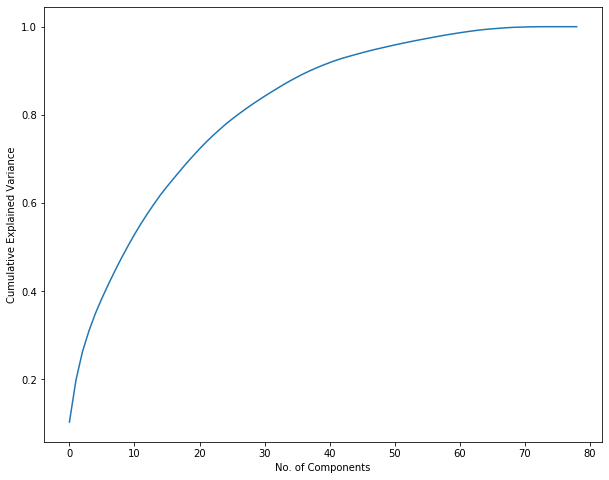

In [69]:
plt.figure(figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No. of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [70]:
pd.DataFrame({
    'PC1': pca.components_[0],
    'PC2': pca.components_[1],
    'PC3': pca.components_[2],
    'Feature': X_scaled_df.columns
}).head(10)

,PC1,PC2,PC3,Feature
0,0.00,0.29,0.15,arpu_8
1,-0.11,0.11,0.15,onnet_mou_8
2,-0.10,0.20,0.11,offnet_mou_8
3,-0.01,0.05,0.01,roam_ic_mou_8
4,-0.02,0.07,0.03,roam_og_mou_8
5,-0.03,0.10,0.02,loc_og_t2t_mou_8
6,-0.03,0.18,-0.03,loc_og_t2m_mou_8
7,0.01,0.11,-0.09,loc_og_t2f_mou_8
8,-0.01,0.02,0.08,loc_og_t2c_mou_8
9,-0.11,0.07,0.16,std_og_t2t_mou_8


In [71]:
round(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)[50], 2)

95.87

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=100)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20967, 79)
(8986, 79)
(20967,)
(8986,)


## SMOTE (Synthetic Minority Over-sampling Technique)

In [73]:
smote = SMOTE()
X_train_smt, y_train_smt = smote.fit_sample(X_train, y_train)

print(X_train_smt.shape)
print(y_train_smt.shape)

(38430, 79)
(38430,)


## PCA (50 components)

In [74]:
pca = IncrementalPCA(n_components=50)    
X_train_pca = pca.fit_transform(X_train_smt)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

(38430, 50)
(8986, 50)


In [75]:
X_train, X_test, y_train, y_test = X_train_pca, X_test_pca, y_train_smt, y_test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38430, 50)
(8986, 50)
(38430,)
(8986,)


In [198]:
# To list all the mdoels and their metrics
columns = ['Model Name', 'Accuracy', 'Recall', 'Precision', 'F1', 'AUC']
model_metrics = pd.DataFrame(columns=columns)
model_metrics

,Model Name,Accuracy,Recall,Precision,F1,AUC


#### Utility Functions

In [128]:
def insert_metric(name, accuracy, recall, precision, f1, auc):
    model_metrics.loc[len(model_metrics)] = [name, accuracy, recall, precision, f1, auc]
    return model_metrics

def plot_cm(cm):
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, square=True, fmt='g', cmap='bwr', vmin=0, vmax=2000)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

def plot_cv_params(param_a, param_b, params, cv_results):
    plt.figure(figsize=(28, 8))

    param_b_vals = params[param_b]

    for idx, param_b_val in enumerate(param_b_vals):
        plt.subplot(131 + idx)
        plt.rc('font', size=16)

        param_cv = cv_results[cv_results[f'param_{param_b}'] == param_b_val]
        plt.plot(param_cv[f'param_{param_a}'], param_cv['mean_test_score'])
        plt.plot(param_cv[f'param_{param_a}'], param_cv['mean_train_score'])
        plt.grid()
        plt.xlabel(param_a)
        plt.ylabel('Accuracy')
        plt.title(f'{param_b} = {param_b_val}')
        plt.ylim([0.75, 1])
        plt.legend(['Test Accuracy', 'Train Accuracy'], loc='lower right')

# 1. Random Forest

In [87]:
model_rf_def = RandomForestClassifier()
model_rf_def.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
y_pred = model_rf_def.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
auc = round(roc_auc_score(y_test, y_pred), 2)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)
print('AUC:', auc)

Accuracy: 0.92
Recall: 0.57
Precision: 0.46
F1: 0.51
AUC: 0.76


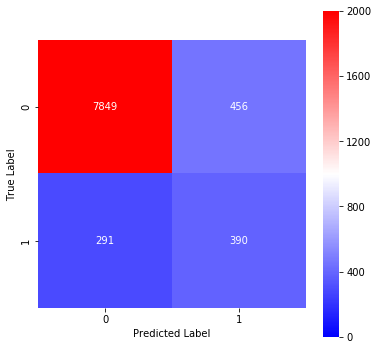

In [89]:
plot_cm(confusion_matrix(y_test, y_pred))

In [90]:
insert_metric('Random Forest', accuracy, recall, precision, f1, auc)

,Model Name,Accuracy,Recall,Precision,F1,AUC
0,SVM (linear),0.83,0.82,0.29,0.43,0.83
1,SVM (non-linear),0.87,0.77,0.35,0.48,0.82
2,SVM (final),0.92,0.43,0.44,0.44,0.69
3,Random Forest,0.92,0.57,0.46,0.51,0.76


#### Hyperparameter Tuning

In [91]:
folds = 5

# Hyperparameters
params = {
    'max_depth': [10, 15, 20],
    'max_features': [20, 60],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [10, 20]
}

model_rf = RandomForestClassifier(n_estimators=200, random_state=100)

gs_rf = GridSearchCV(model_rf, params, cv=folds, scoring='accuracy', return_train_score=True, n_jobs=-1, verbose=10)
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 45.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=100,
                                 

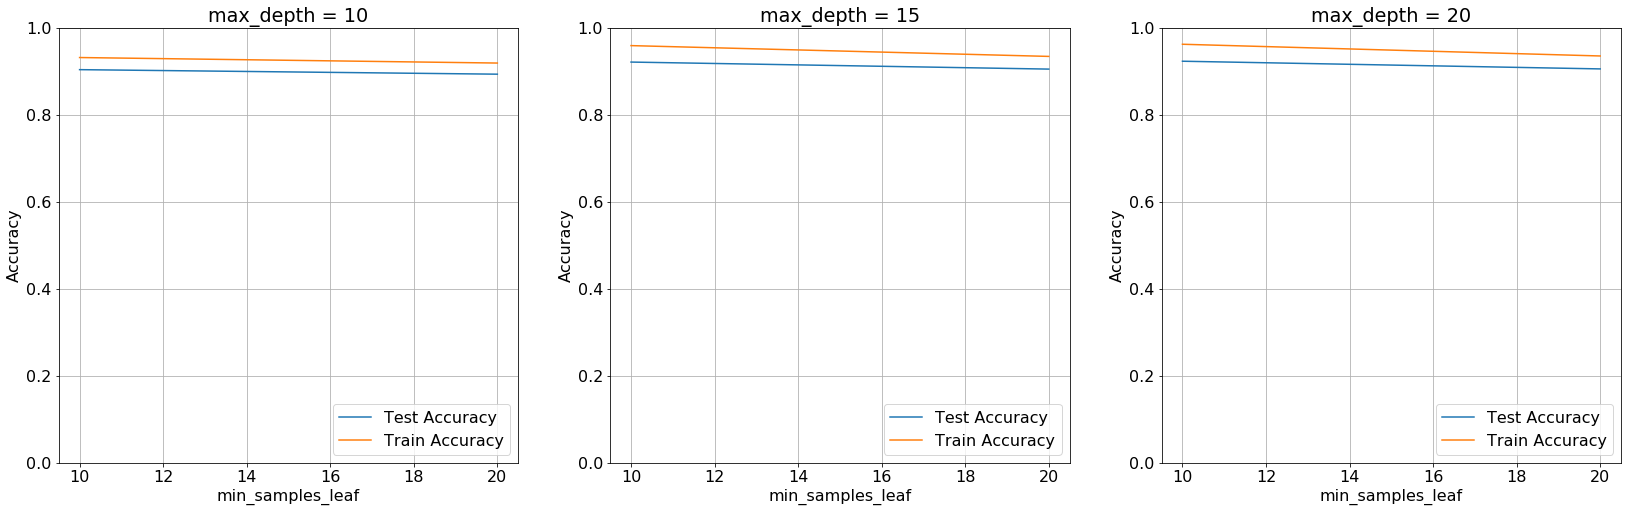

In [113]:
rf_cv_results = pd.DataFrame(gs_rf.cv_results_)
plot_cv_params('min_samples_leaf', 'max_depth', params, rf_cv_results)

In [92]:
print(f'Best Params: {gs_rf.best_params_}')
print(f'Best Score: {gs_rf.best_score_}')

Best Params: {'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best Score: 0.922950819672131


- The best params seems to be the optimal. We will use that.

Accuracy: 0.9
Recall: 0.7
Precision: 0.42
F1: 0.52
AUC: 0.81


,Model Name,Accuracy,Recall,Precision,F1,AUC
0,SVM (linear),0.83,0.82,0.29,0.43,0.83
1,SVM (non-linear),0.87,0.77,0.35,0.48,0.82
2,SVM (final),0.92,0.43,0.44,0.44,0.69
3,Random Forest,0.92,0.57,0.46,0.51,0.76
4,Random Forest (final),0.90,0.70,0.42,0.52,0.81


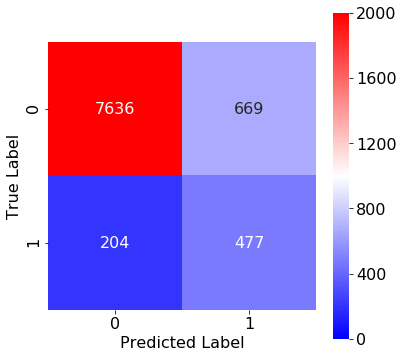

In [115]:
final_rf_model = gs_rf.best_estimator_

y_pred = final_rf_model.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
auc = round(roc_auc_score(y_test, y_pred), 2)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)
print('AUC:', auc)

plot_cm(confusion_matrix(y_test, y_pred))

insert_metric('Random Forest (final)', accuracy, recall, precision, f1, auc)

# 2. SVM

#### Linear

In [78]:
model_svm_lin = SVC(kernel='linear', random_state=100)
model_svm_lin.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=100, shrinking=True, tol=0.001,
    verbose=False)

In [79]:
y_pred = model_svm_lin.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
auc = round(roc_auc_score(y_test, y_pred), 2)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)
print('AUC:', auc)

Accuracy: 0.83
Recall: 0.82
Precision: 0.29
F1: 0.43
AUC: 0.83


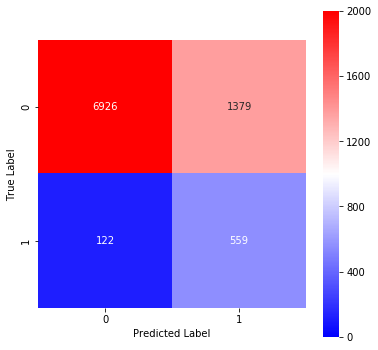

In [80]:
plot_cm(confusion_matrix(y_test, y_pred))

In [81]:
insert_metric('SVM (linear)', accuracy, recall, precision, f1, auc)

,Model Name,Accuracy,Recall,Precision,F1,AUC
0,SVM (linear),0.83,0.82,0.29,0.43,0.83


#### Non-Linear

In [82]:
model_svm_rbf = SVC(kernel='rbf', random_state=100)
model_svm_rbf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=100, shrinking=True, tol=0.001,
    verbose=False)

In [83]:
y_pred = model_svm_rbf.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
auc = round(roc_auc_score(y_test, y_pred), 2)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)
print('AUC:', auc)

Accuracy: 0.87
Recall: 0.77
Precision: 0.35
F1: 0.48
AUC: 0.82


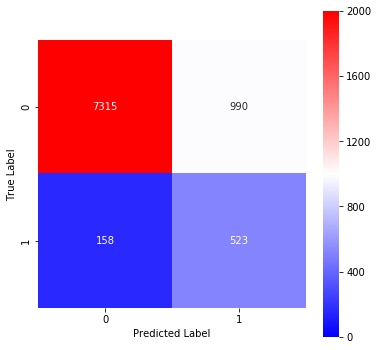

In [84]:
plot_cm(confusion_matrix(y_test, y_pred))

In [85]:
insert_metric('SVM (non-linear)', accuracy, recall, precision, f1, auc)

,Model Name,Accuracy,Recall,Precision,F1,AUC
0,SVM (linear),0.83,0.82,0.29,0.43,0.83
1,SVM (non-linear),0.87,0.77,0.35,0.48,0.82


- Non-linear model is giving slightly better accuracy. So, we'll choose the non-linear model for hyperparameter tuning

#### Hyperparameter Tuning

In [377]:
folds = 5

# Hyperparameters
params = {
    'C': [10, 50, 100],
    'gamma': [0.1, 0.01, 0.001]
}

model_svm = SVC(kernel='rbf', random_state=100)

gs_svm = GridSearchCV(model_svm, params, cv=folds, scoring='accuracy', return_train_score=True, n_jobs=-1, verbose=10)
gs_svm.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 47.3min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 47.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=100, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [10, 50, 100], 'gamma': [0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=10)

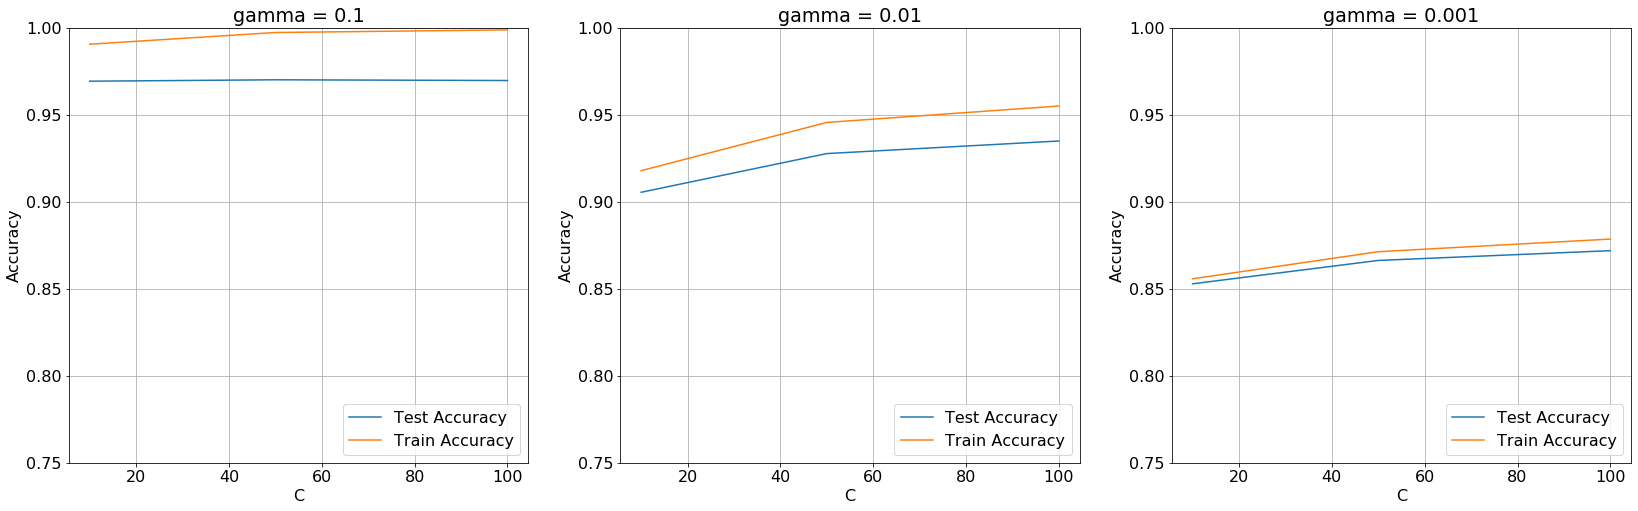

In [407]:
svm_cv_results = pd.DataFrame(gs_svm.cv_results_)
plot_cv_params('C', 'gamma', params, svm_cv_results)

In [378]:
print(f'Best Params: {gs_svm.best_params_}')
print(f'Best Score: {gs_svm.best_score_}')

Best Params: {'C': 50, 'gamma': 0.1}
Best Score: 0.9701795472287275


- Gridsearch selected C=50 and Gamma=0.1 as best params. But this model seems to be a overfitting.
- We'll choose C=10 and Gamma=0.1 as params instead.

Accuracy: 0.92
Recall: 0.43
Precision: 0.44
F1: 0.44
AUC: 0.69


,Model Name,Accuracy,Recall,Precision,F1,AUC
0,SVM (linear),0.83,0.82,0.29,0.43,0.83
1,SVM (non-linear),0.87,0.77,0.35,0.48,0.82
2,SVM (final),0.92,0.43,0.44,0.44,0.69


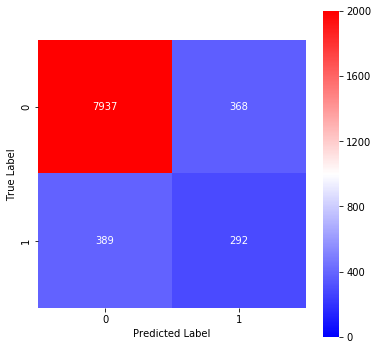

In [86]:
final_svm_model = SVC(kernel='rbf', C=50, gamma=0.1, random_state=100)
final_svm_model.fit(X_train, y_train)

y_pred = final_svm_model.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
auc = round(roc_auc_score(y_test, y_pred), 2)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)
print('AUC:', auc)

plot_cm(confusion_matrix(y_test, y_pred))

insert_metric('SVM (final)', accuracy, recall, precision, f1, auc)

# 3. XGBoost

In [119]:
model_xgb_def = XGBClassifier()
model_xgb_def.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [120]:
y_pred = model_xgb_def.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
auc = round(roc_auc_score(y_test, y_pred), 2)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)
print('AUC:', auc)

Accuracy: 0.9
Recall: 0.64
Precision: 0.41
F1: 0.5
AUC: 0.78


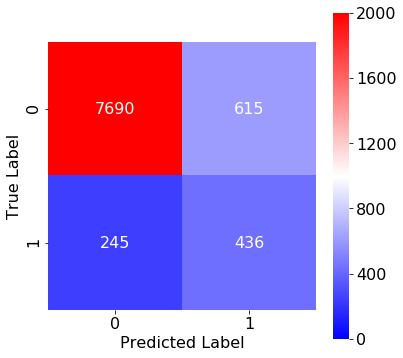

In [121]:
plot_cm(confusion_matrix(y_test, y_pred))

In [122]:
insert_metric('XGBoost', accuracy, recall, precision, f1, auc)

,Model Name,Accuracy,Recall,Precision,F1,AUC
0,SVM (linear),0.83,0.82,0.29,0.43,0.83
1,SVM (non-linear),0.87,0.77,0.35,0.48,0.82
2,SVM (final),0.92,0.43,0.44,0.44,0.69
3,Random Forest,0.92,0.57,0.46,0.51,0.76
4,Random Forest (final),0.90,0.70,0.42,0.52,0.81
5,XGBoost,0.90,0.64,0.41,0.50,0.78


#### Hyperparameter Tuning

In [123]:
folds = 5

# Hyperparameters
params = {
    'learning_rate': [0.2, 0.3, 0.4], 
    'subsample': [0.3, 0.4, 0.5]
}

model_xgb = XGBClassifier(n_estimator=200, random_state=100)

gs_xgb = GridSearchCV(model_xgb, params, cv=folds, scoring='accuracy', return_train_score=True, n_jobs=-1, verbose=10)
gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  5.9min remaining:   16.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=100, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None

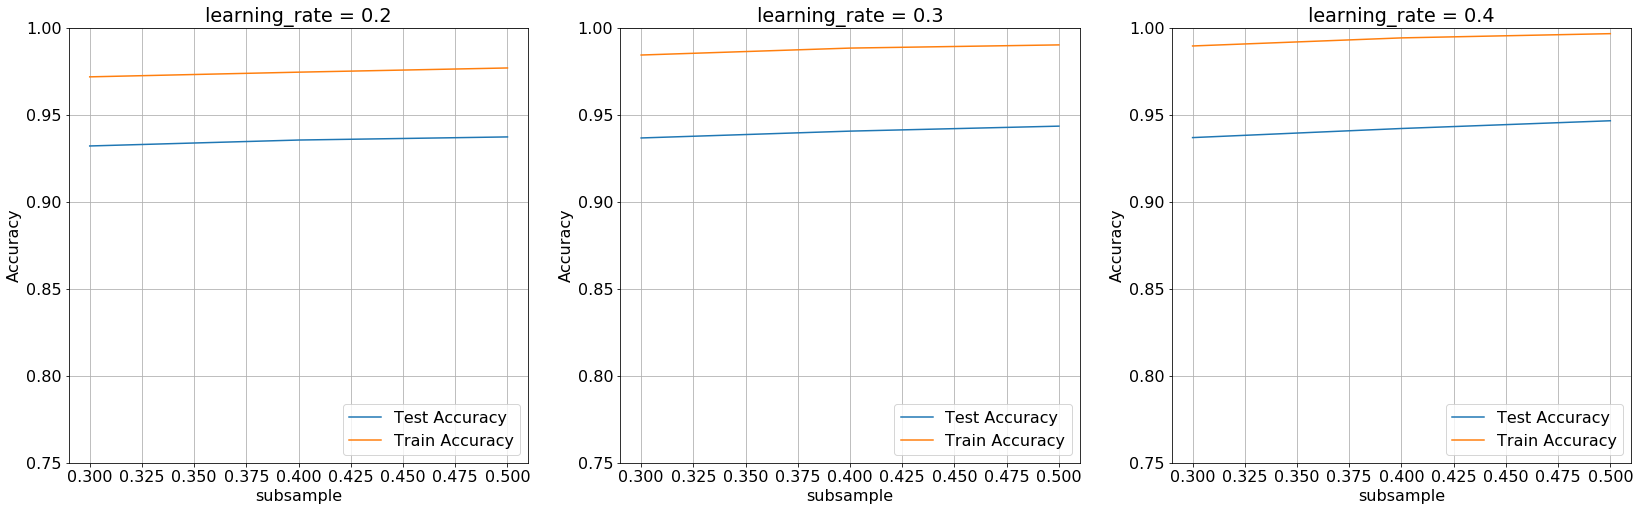

In [129]:
xgb_cv_results = pd.DataFrame(gs_xgb.cv_results_)
plot_cv_params('subsample', 'learning_rate', params, xgb_cv_results)

In [124]:
print(f'Best Params: {gs_xgb.best_params_}')
print(f'Best Score: {gs_xgb.best_score_}')

Best Params: {'learning_rate': 0.4, 'subsample': 0.5}
Best Score: 0.9466302367941714


- The best params seems to be overfitting.
- We'll choose learning rate=0.4 and subsample=0.3 instead.

Accuracy: 0.89
Recall: 0.6
Precision: 0.37
F1: 0.46
AUC: 0.76


,Model Name,Accuracy,Recall,Precision,F1,AUC
0,SVM (linear),0.83,0.82,0.29,0.43,0.83
1,SVM (non-linear),0.87,0.77,0.35,0.48,0.82
2,SVM (final),0.92,0.43,0.44,0.44,0.69
3,Random Forest,0.92,0.57,0.46,0.51,0.76
4,Random Forest (final),0.90,0.70,0.42,0.52,0.81
5,XGBoost,0.90,0.64,0.41,0.50,0.78
6,XGBoost (final),0.89,0.60,0.37,0.46,0.76


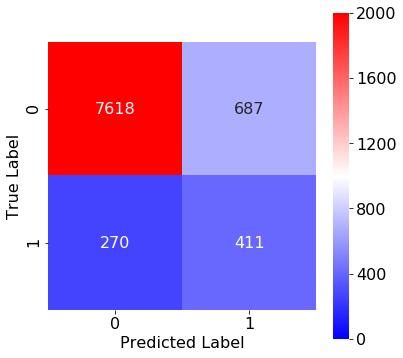

In [131]:
final_xgb_model = XGBClassifier(learning_rate=0.4, subsample=0.3, n_estimator=200, random_state=100)
final_xgb_model.fit(X_train, y_train)

y_pred = final_xgb_model.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
auc = round(roc_auc_score(y_test, y_pred), 2)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)
print('AUC:', auc)

plot_cm(confusion_matrix(y_test, y_pred))

insert_metric('XGBoost (final)', accuracy, recall, precision, f1, auc)

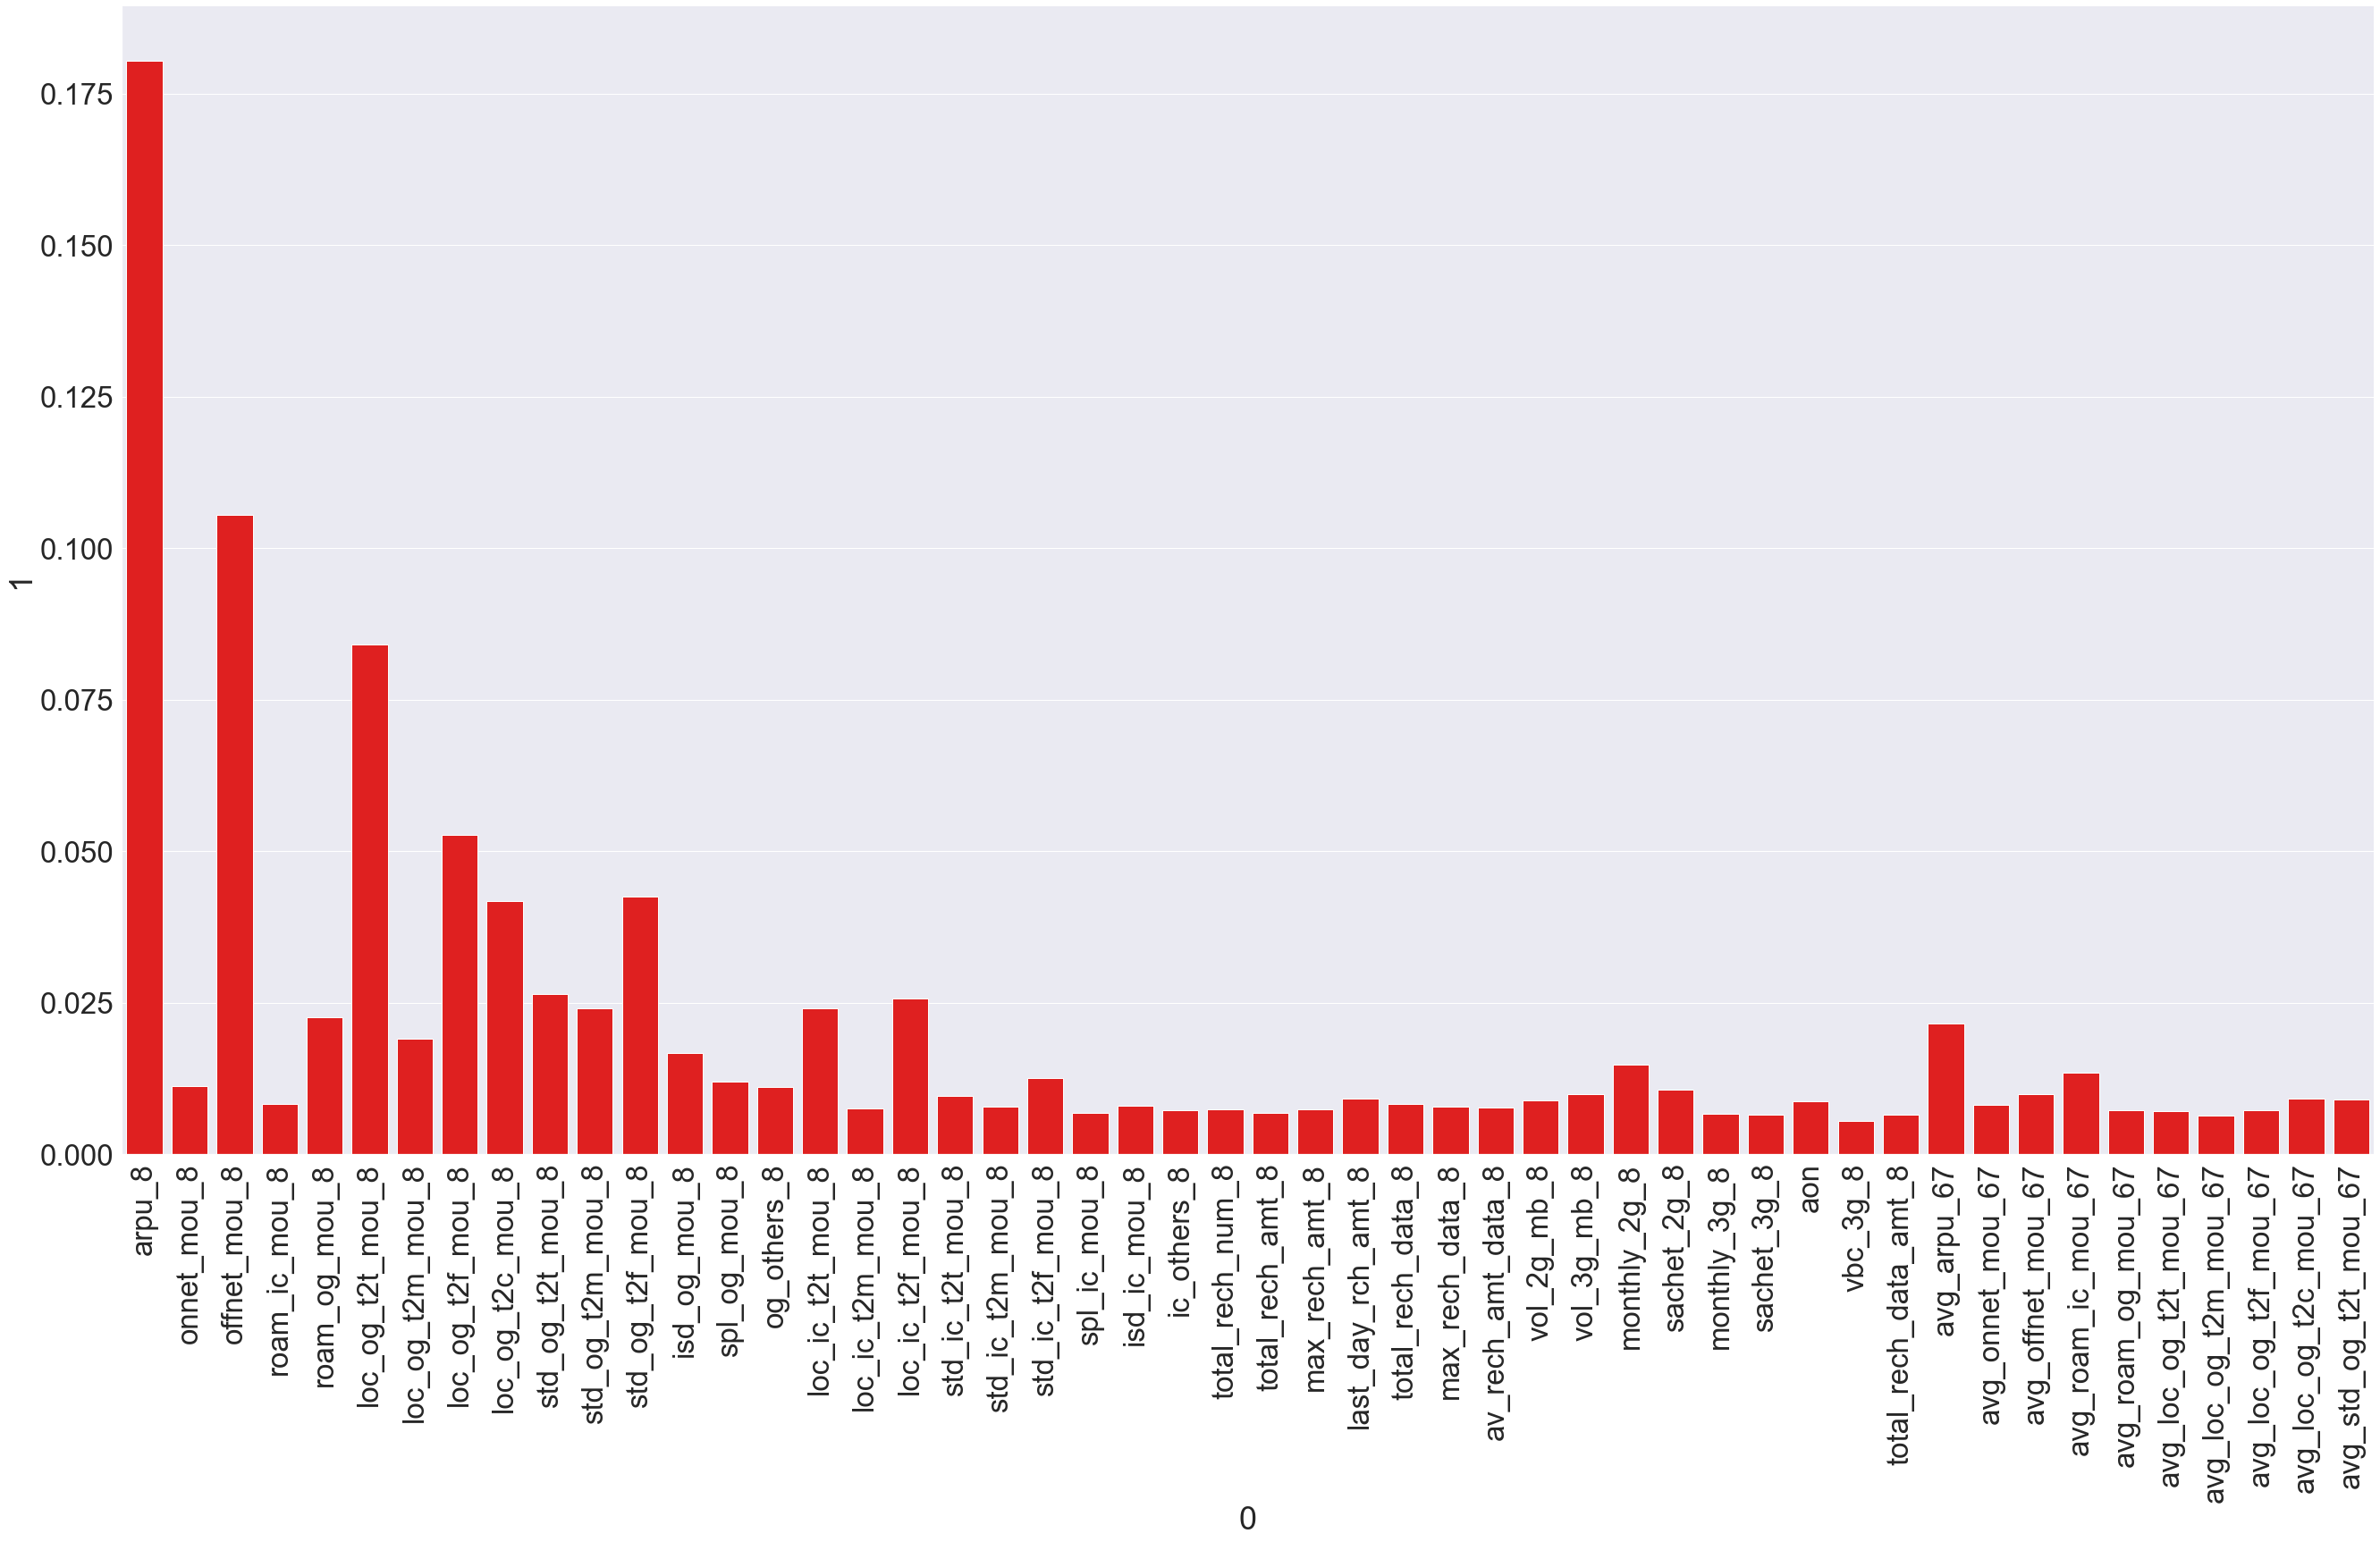

In [207]:
sns.set(font_scale=3)
feature_importance = pd.DataFrame(dict(zip(X_scaled_df.columns, final_rf_model.feature_importances_)).items())
ax = sns.catplot(data=feature_importance, x=0, y=1, kind='bar', size=20, aspect=2, palette=sns.color_palette(['red']))
ax.set_xticklabels(rotation=90)

---
# Outcomes
- Customers who have been using for less than 5 years are more likely to churn. Company should focus on the new customers more.
- Average revenue seems to be the most import feature for prediction.
- Calls outside the network and local outgoing calls made to same operator, fixedline, and call are some of the other important features for churn prediction.
- Not many High-Value customers churn which is a good.

In [197]:
model_metrics

,Model Name,Accuracy,Recall,Precision,F1,AUC
0,SVM (linear),0.83,0.82,0.29,0.43,0.83
1,SVM (non-linear),0.87,0.77,0.35,0.48,0.82
2,SVM (final),0.92,0.43,0.44,0.44,0.69
3,Random Forest,0.92,0.57,0.46,0.51,0.76
4,Random Forest (final),0.90,0.70,0.42,0.52,0.81
5,XGBoost,0.90,0.64,0.41,0.50,0.78
6,XGBoost (final),0.89,0.60,0.37,0.46,0.76


- Random Forest with tunes parameters seems to be performing the best.
- SVM also performed pretty good with an accuracy of 92%
- These 2 models can be used for predictions